In [10]:
# load the library
library(DESeq2)
library(tidyverse)
library(dplyr)
library(ggplot2)
library(RColorBrewer)
library(circlize)
library("writexl")
library(ggrepel)
sessionInfo()

circlize version 0.4.15
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visualization
  in R. Bioinformatics 2014.

This message can be suppressed by:
  suppressPackageStartupMessages(library(circlize))




R version 4.3.1 (2023-06-16)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux 8.9 (Ootpa)

Matrix products: default
BLAS/LAPACK: /maps/projects/dan1/people/bns631/.conda/envs/bulk_env/lib/libopenblasp-r0.3.23.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=en_GB.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_GB.UTF-8        LC_COLLATE=en_GB.UTF-8    
 [5] LC_MONETARY=en_GB.UTF-8    LC_MESSAGES=en_GB.UTF-8   
 [7] LC_PAPER=en_GB.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_GB.UTF-8 LC_IDENTIFICATION=C       

time zone: Europe/Copenhagen
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] ggrepel_0.9.3               writexl_1.4.2              
 [3] circlize_0.4.15             RColorBrewer_1.1-3         
 [5] lubridate_1.9.2             forcats_1.0.0 

In [2]:
# Read and prepare the count data
rawCounts <- read.delim("salmon.merged.gene_counts.tsv")
rownames(rawCounts) <- rawCounts$gene_name
rawCounts$gene_id <- NULL
rawCounts$gene_name <- NULL
rawCounts <- rawCounts %>% mutate_if(is.double, as.integer)
head(rawCounts)

,RS1_FGF8_15m_rep1,RS10_FGF17_15m_rep2,RS11_FGF8_1h_rep2,RS12_FGF17_1h_rep2,RS13_FGF8_4h_rep2,RS14_FGF17_4h_rep2,RS15_FGF8_24h_rep2,RS16_FGF17_24h_rep2,RS17_FGF8_15m_rep3,RS18_FGF17_15m_rep3,⋯,RS22_FGF17_4h_rep3,RS23_FGF8_24h_rep3,RS24_FGF17_24h_rep3,RS3_FGF8_1h_rep1,RS4_FGF17_1h_rep1,RS5_FGF8_4h_rep1,RS6_FGF17_4h_rep1,RS7_FGF8_24h_rep1,RS8_FGF17_24h_rep1,RS9_FGF8_15m_rep2
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
A1BG,157,189,208,213,121,145,180,155,174,225,⋯,152,223,194,184,153,95,122,130,115,208
A1BG-AS1,115,91,106,115,68,80,82,75,86,109,⋯,72,102,125,113,96,102,97,71,92,131
A1CF,1,1,0,0,1,2,1,1,0,0,⋯,2,2,1,2,1,0,2,5,3,0
A2M,22,13,21,8,166,235,980,516,13,18,⋯,365,742,844,35,24,205,254,838,762,8
A2M-AS1,6,2,1,5,0,5,7,6,7,4,⋯,3,8,10,6,2,3,6,4,7,4
A2ML1,0,0,3,1,0,0,0,0,1,0,⋯,0,2,0,4,0,0,0,0,0,1


In [3]:
# Create the sample dataframe
sample <- colnames(rawCounts)
condition <- rep()
time <- rep()
condition_time <- rep()

for(item in colnames(rawCounts)){
    temp <- str_match(item, "_\\s*(.*_?)\\s*_")[,2]
    condition_time <- append(condition_time, temp)
    temp <- strsplit(temp,'_')[[1]]
    condition <- append(condition,temp[1])
    time <- append(time,temp[2])
}

sample_df <- data.frame(sample = sample, condition=condition, time=time, condition_time=condition_time)
rownames(sample_df) <- sample_df$sample
sample_df$sample <- NULL
sample_df['condition'] <- lapply(sample_df['condition'] , factor)
sample_df['time'] <- lapply(sample_df['time'] , factor)
sample_df['condition_time'] <- lapply(sample_df['condition_time'] , factor)
head(sample_df)

,condition,time,condition_time
,<fct>,<fct>,<fct>
RS1_FGF8_15m_rep1,FGF8,15m,FGF8_15m
RS10_FGF17_15m_rep2,FGF17,15m,FGF17_15m
RS11_FGF8_1h_rep2,FGF8,1h,FGF8_1h
RS12_FGF17_1h_rep2,FGF17,1h,FGF17_1h
RS13_FGF8_4h_rep2,FGF8,4h,FGF8_4h
RS14_FGF17_4h_rep2,FGF17,4h,FGF17_4h


In [4]:
# Ensure that the sample dataframe and count matrix are ordered correctly
print(paste0('Count columns and sample dataframe rows are in the same order: ' ,all(colnames(rawCounts) == rownames(sample_df))))

[1] "Count columns and sample dataframe rows are in the same order: TRUE"


In [5]:
# Create deseq2 object by specifying the expreimential design
# Here we are comparing FGF8 and FGF17 conditions in four different timepoints (15m, 1h, 4h, 24h). Each sample has three biological replicates
dds <- DESeqDataSetFromMatrix(countData=rawCounts, colData=sample_df, design= ~condition + time + condition:time)

# Filtering
# Remove rows with low gene counts
keep <- rowSums(counts(dds)) >= 50
dds <- dds[keep,]

# at least 3 samples with a count of 10 or higher
keep <- rowSums(counts(dds) >= 10) >= 3
dds <- dds[keep,]
print(dds)

# Performs normalization and estimates DE genes 
dds <- DESeq(dds)
# Print the coefficents
resultsNames(dds)

class: DESeqDataSet 
dim: 16432 24 
metadata(1): version
assays(1): counts
rownames(16432): A1BG A1BG-AS1 ... ZZEF1 ZZZ3
rowData names(0):
colnames(24): RS1_FGF8_15m_rep1 RS10_FGF17_15m_rep2 ...
  RS8_FGF17_24h_rep1 RS9_FGF8_15m_rep2
colData names(3): condition time condition_time


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



[1] "Intercept"               "condition_FGF8_vs_FGF17"
[3] "time_1h_vs_15m"          "time_24h_vs_15m"        
[5] "time_4h_vs_15m"          "conditionFGF8.time1h"   
[7] "conditionFGF8.time24h"   "conditionFGF8.time4h"

In [8]:
rlog_out = rlog(dds,blind=F)
write.csv(assay(rlog_out), file="deseq2_output/norm_counts.csv")

png 
  2

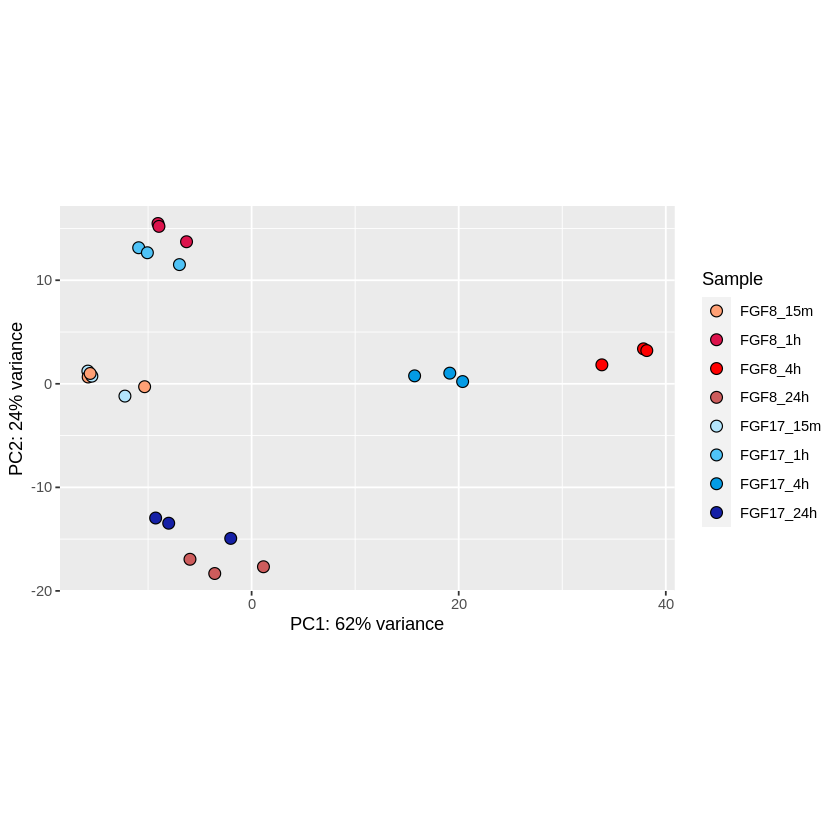

In [6]:
#temp_dds <- dds
temp_dds <- dds
temp_dds$condition_time <- factor(temp_dds$condition_time, levels = c('FGF8_15m', 'FGF8_1h', 'FGF8_4h', 'FGF8_24h', 'FGF17_15m', 'FGF17_1h', 'FGF17_4h', 'FGF17_24h'))
color_vec <- c("FGF8_15m" = "#FFA075", "FGF8_1h"="#DC134C", "FGF8_4h"="#FF0000", "FGF8_24h" = "#CD5C5C", "FGF17_15m"="#B3E5FC", "FGF17_1h"="#4FC3F7", "FGF17_4h" = "#039BE5", "FGF17_24h"="#1520A6")
vsdata <- vst(temp_dds, blind=FALSE)
pcaData <- plotPCA(vsdata, intgroup='condition_time', returnData=T)
percentVar <- round(100*attr(pcaData, 'percentVar'))
pcaplot <- ggplot(pcaData, aes(PC1, PC2, color = condition_time)) + geom_point(colour="black", shape=21, size = 3, 
    aes(fill = factor(condition_time))) +
    scale_fill_manual(values=color_vec, name='Sample') + 
    #scale_fill_discrete(limits = c('FGF8_15m', 'FGF8_1h', 'FGF8_4h', 'FGF8_24h', 'FGF17_15m', 'FGF17_1h', 'FGF17_4h', 'FGF17_24h')) +
    #scale_colour_manual(values=color_vec)
    xlab(paste0("PC1: ",percentVar[1],"% variance")) +
    ylab(paste0("PC2: ",percentVar[2],"% variance")) + 
    coord_fixed()
#plotPCA(vsdata, intgroup=c('FGF8_15m', 'FGF17_15m', 'FGF8_1h', 'FGF17_1h', 'FGF8_4h', 'FGF17_4h', 'FGF8_24h', 'FGF17_24h'))
png("deseq2_output/pca_plot.png",width = 265, height = 125, units='mm', res = 300)
plot(1:10, 1:10, mar=c(3.5,0,3,0))
print(pcaplot)
dev.off()
pcaplot

In [7]:
# For each timepoint extracting the results to a dataframe

# Getting the difference between conditions at timepoint 15m
res_15m <- results(dds, name='condition_FGF8_vs_FGF17', alpha = 0.05, test='Wald')
# Getting the difference between conditions the rest of the timepoints
res_1h <- results(dds, contrast=list(c('condition_FGF8_vs_FGF17', 'conditionFGF8.time1h')), alpha = 0.05, test='Wald')
res_4h <- results(dds, contrast=list(c('condition_FGF8_vs_FGF17', 'conditionFGF8.time4h')), alpha = 0.05, test='Wald')
res_24h <- results(dds, contrast=list(c('condition_FGF8_vs_FGF17', 'conditionFGF8.time24h')), alpha = 0.05, test='Wald')

In [40]:
# Order the deseq result dataframe and remove rows with NA values
resOrder_15m <- res_15m[order(res_15m$padj),]
resOrder_15m$sig <- ifelse(resOrder_15m$padj <= 0.05, T, F)
resOrder_15m <- na.omit(resOrder_15m)
write.csv(resOrder_15m, 'deseq2_output/results_15m.csv')

resOrder_1h <- res_1h[order(res_1h$padj),]
resOrder_1h$sig <- ifelse(resOrder_1h$padj <= 0.05, T, F)
resOrder_1h <- na.omit(resOrder_1h)
write.csv(resOrder_1h, 'deseq2_output/results_1h.csv')


resOrder_4h <- res_4h[order(res_4h$padj),]
resOrder_4h$sig <- ifelse(resOrder_4h$padj <= 0.05, T, F)
resOrder_4h <- na.omit(resOrder_4h)
write.csv(resOrder_4h, 'deseq2_output/results_4h.csv')


resOrder_24h <- res_24h[order(res_24h$padj),]
resOrder_24h$sig <- ifelse(resOrder_24h$padj <= 0.05, T, F)
resOrder_24h <- na.omit(resOrder_24h)
write.csv(resOrder_24h, 'deseq2_output/results_24h.csv')


         X   baseMean log2FoldChange      lfcSE      stat       pvalue
1    ZFP36 1533.53786      1.0723620 0.14511022  7.389982 1.468482e-13
2     EGR2 3167.36687      0.8205240 0.12535711  6.545492 5.929966e-11
3     FOSB 3601.53811      0.9417444 0.14313937  6.579213 4.729443e-11
4     EGR4  531.65364      1.1616608 0.18168978  6.393649 1.619726e-10
5     EGR3 5724.33814      0.8216506 0.13685616  6.003753 1.928083e-09
6    TRIB1 2263.13383      0.7083572 0.12039425  5.883647 4.013237e-09
7    NR4A1 3180.87356      0.7214506 0.12471168  5.784948 7.253461e-09
8     BTG2 4497.91804      0.6900890 0.12804537  5.389410 7.068934e-08
9  SERTAD3  830.99117      0.4213733 0.07878754  5.348222 8.882246e-08
10     ARC 1008.06517      1.0274848 0.19321740  5.317765 1.050494e-07
11 CENPVP1   87.14542    -22.6311010 4.29485778 -5.269348 1.369090e-07
12    IER2 7618.05849      0.5052882 0.09977522  5.064265 4.099780e-07
13    IER5 1408.15547      0.4377059 0.09500452  4.607211 4.081053e-06
15   D

Saving 6.67 x 6.67 in image


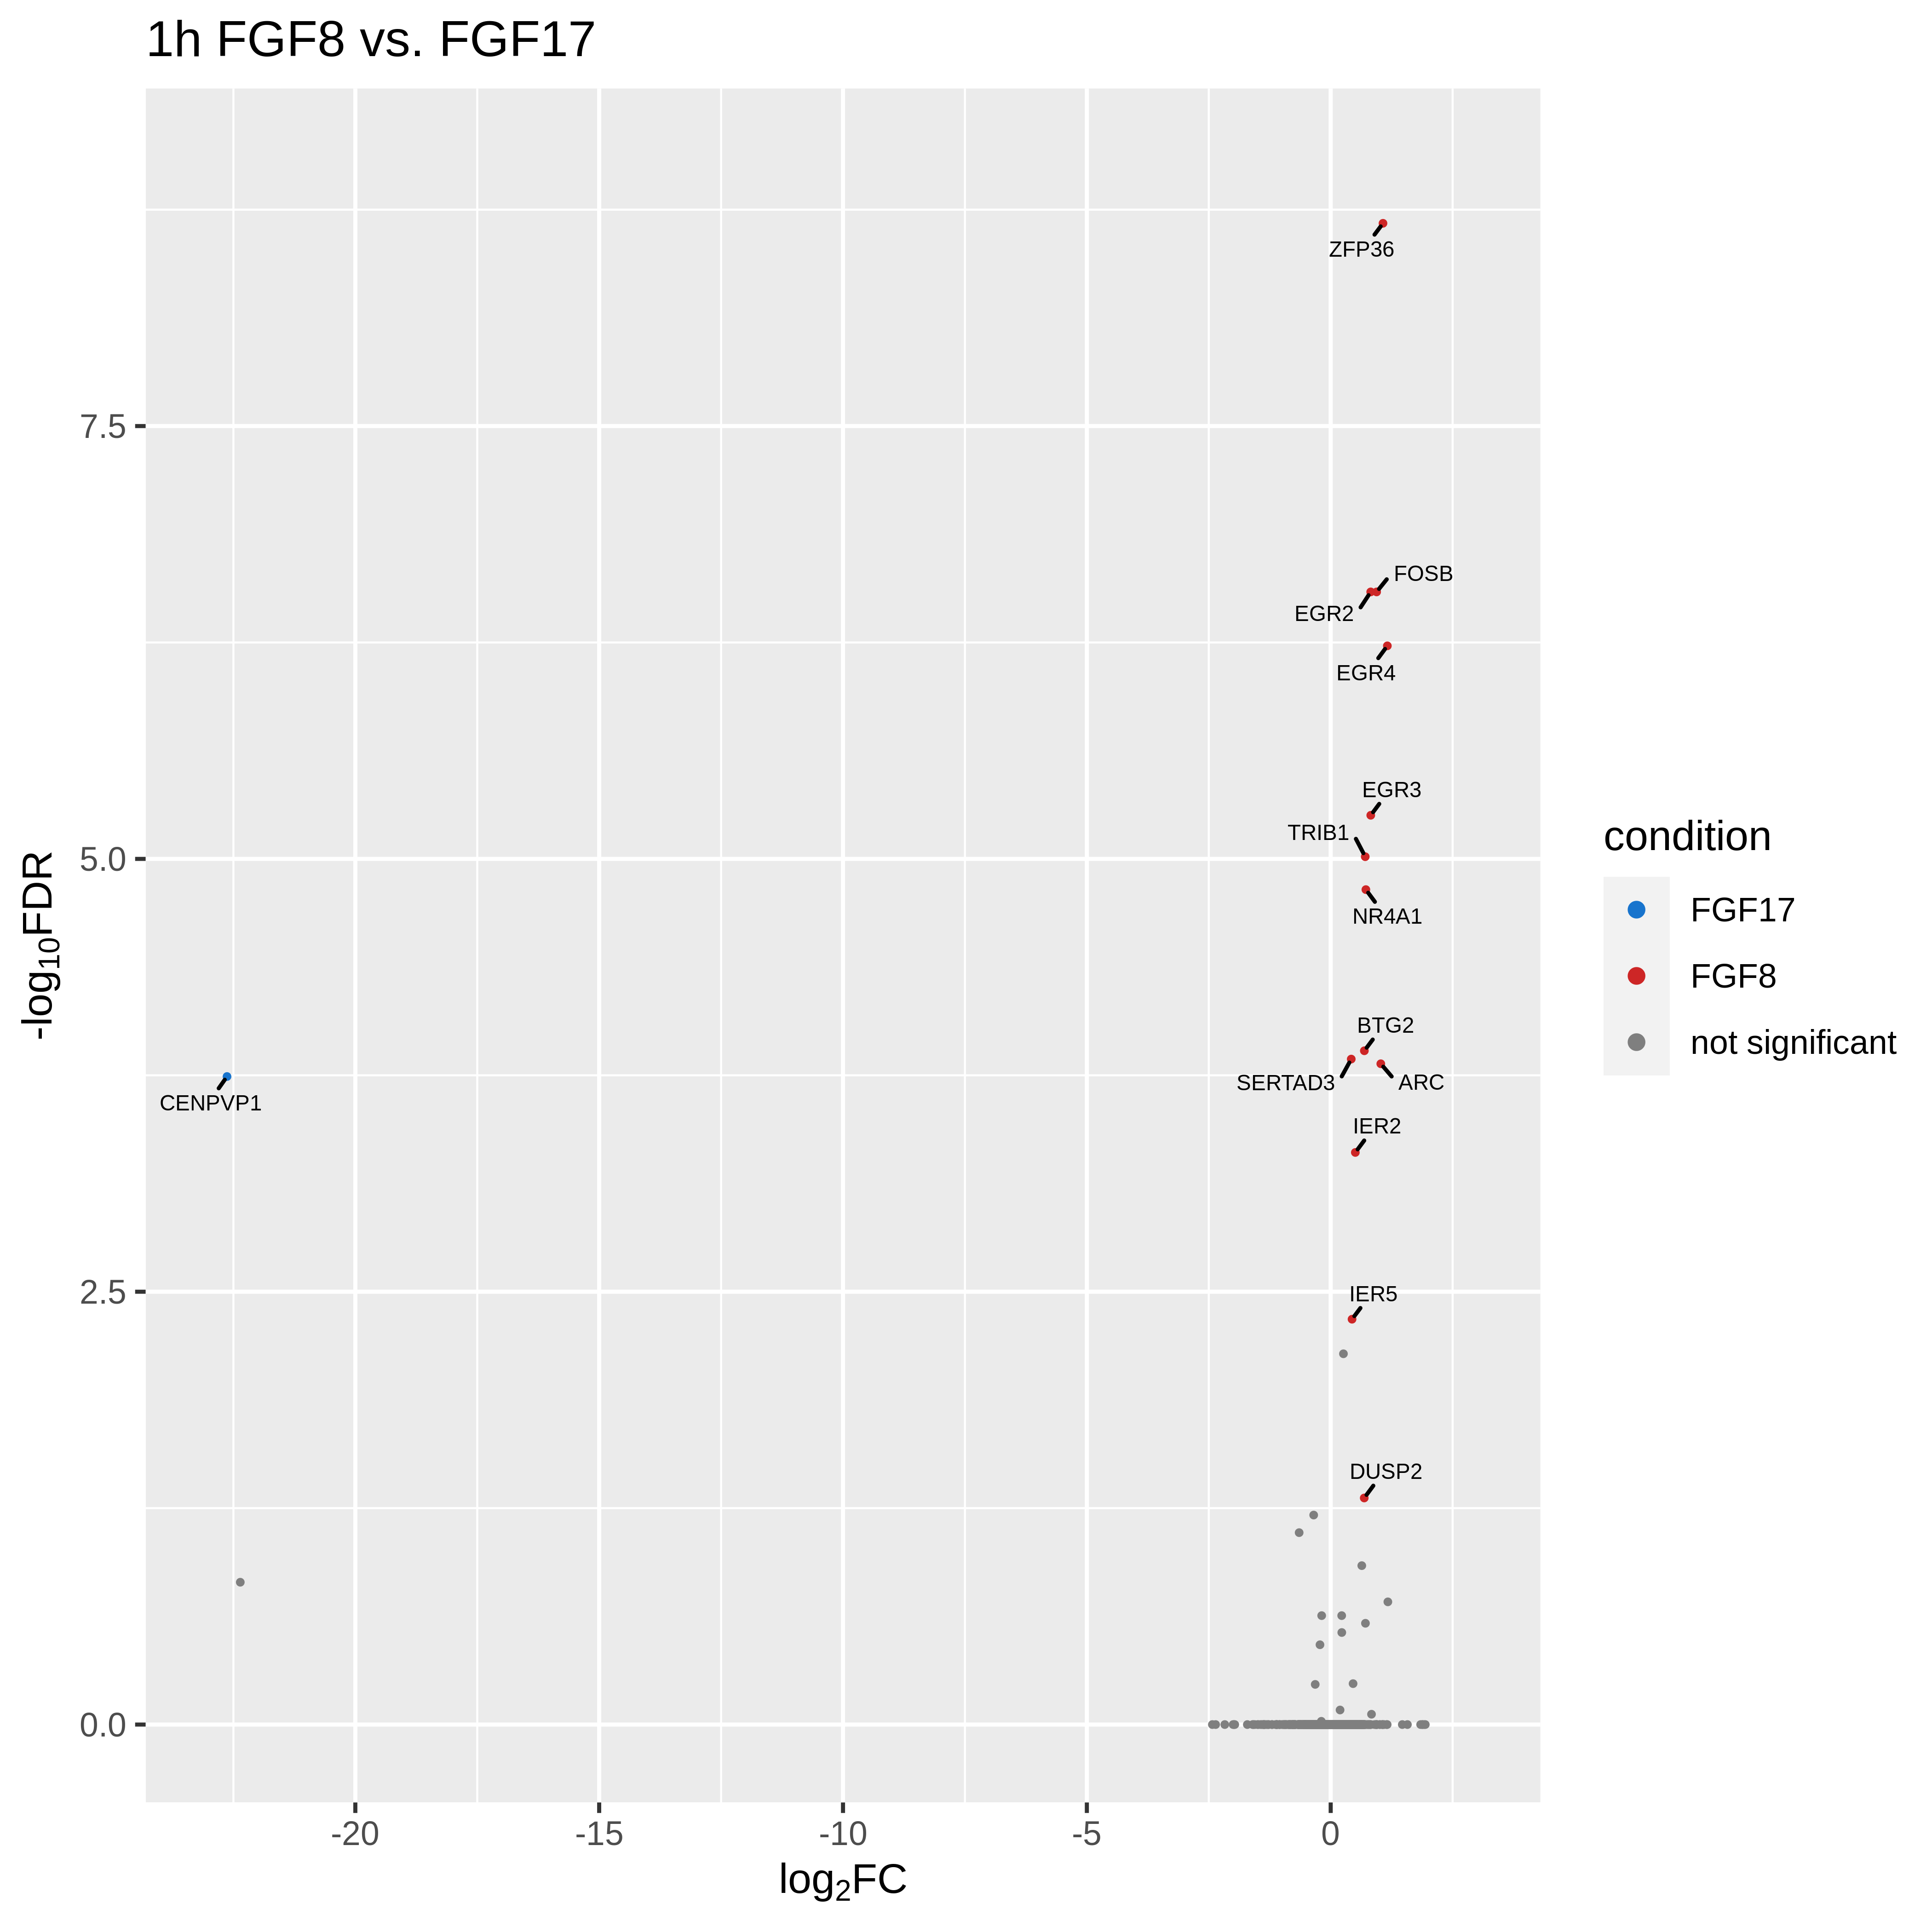

In [12]:
# Plotting DE genes at 1h
res_1h <- read.csv('deseq2_output/results_1h.csv')
res_1h <- res_1h %>% 
  mutate(
    condition = case_when(log2FoldChange >= log(1.3) & padj <= 0.05 ~ "FGF8",
                           log2FoldChange <= -log(1.3) & padj <= 0.05 ~ "FGF17",
                           TRUE ~ "not significant")
    )

#apcdd1L,rax, wnt7a, fezf2, nkx2-1,fzd5,gdf7,cad2
gene_l = c('ZFP36','EGR2', 'EGR3', 'EGR4', 'DUSP2','IER2','IER5','CENPVP1','FOSB','TRIB1','NR4A1',
          'BTG2','SERTAD3','ARC')

options(repr.plot.res = 600)
p2 <- ggplot(res_1h, aes(log2FoldChange, -log(padj,10))) +
  geom_point(aes(color = condition), size = 2/5) +
  xlim(-23,3) +
  ylim(0,9) +
  xlab(expression("log"[2]*"FC")) + 
  ylab(expression("-log"[10]*"FDR")) +
  scale_color_manual(values = c("dodgerblue3", "firebrick3", "gray50")) +
  guides(colour = guide_legend(override.aes = list(size=1.5))) 

top_genes <- res_1h[res_1h$X %in% gene_l, ] 
print(top_genes)

p3 <-  p2 +
  geom_text_repel(data = top_genes, min.segment.length=0,
                   mapping = aes(log2FoldChange, -log(padj,10), label = X),
                   size = 2) + ggtitle("1h FGF8 vs. FGF17")
ggsave("deseq2_output/updated_1h_volcano.pdf", dpi=600)
p3


# Genes with positive log2FoldChange value are more expressed in FGF8 (up regulated) than in FGF17 samples
# Genes with negative log2FoldChange values are more expressed in FGF17